In [7]:
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D,ZeroPadding2D,BatchNormalization

In [12]:
y, sr = librosa.load('/home/daniel/datatest/nine/d8ee4734_nohash_0.wav',sr=16000,duration=10)

In [13]:
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')

In [4]:
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

/home/daniel/anaconda/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [5]:
plt.subplot(4, 2, 2)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

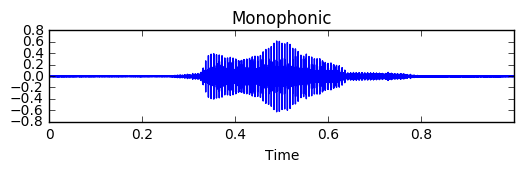

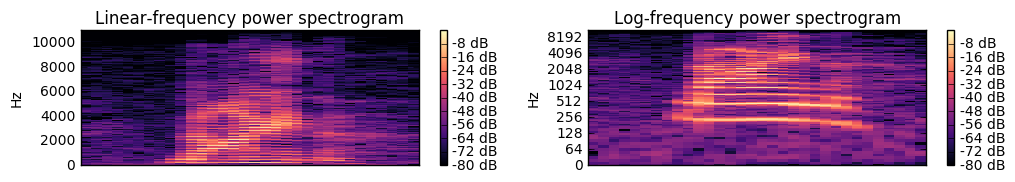

In [6]:
plt.show()

In [14]:
DATA_PATH = "/home/daniel/data/"

In [15]:
hop_length = 320

## LOAD DATA

In [8]:
import numpy as np
import os

DATA_PATH = "/home/daniel/data/"

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


In [9]:
labels, _, _ = get_labels(DATA_PATH)
labels

['marvin',
 'happy',
 'six',
 'up',
 'stop',
 'yes',
 'sheila',
 'zero',
 'dog',
 'right',
 'house',
 'no',
 'two',
 'left',
 'cat',
 'nine',
 'seven',
 'three',
 'wow',
 'bed']

## CONVERT WAV TO MFCC

In [10]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3] #downsampling, 
    mfcc = librosa.feature.mfcc(wave,hop_length=hop_length, sr=16000,n_mfcc=26,n_fft=int(16000*0.04))

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

## SAVE DATA TO FILE NPY

In [11]:
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

## SET PROPORTION FOR DATA TRAINING AND DATA TESTING

In [12]:
def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
        print label
    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

## SET HYPER PARAMETER FOR MODEL

In [ ]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Conv1D
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 26
channel = 1
epochs = 25
batch_size = 100
verbose = 1
num_classes = 20

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [50]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [51]:
def model_lenet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5),strides=1))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [25]:
model13 = model_lenet()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 7s 272us/step - loss: 2.5217 - acc: 0.3281 - val_loss: 1.5945 - val_acc: 0.5031
Epoch 2/25
27200/27200 [==============================] - 6s 216us/step - loss: 1.4439 - acc: 0.5458 - val_loss: 1.4856 - val_acc: 0.5337
Epoch 3/25
27200/27200 [==============================] - 6s 216us/step - loss: 1.2218 - acc: 0.6153 - val_loss: 1.3382 - val_acc: 0.5803
Epoch 4/25
27200/27200 [==============================] - 6s 216us/step - loss: 1.0748 - acc: 0.6597 - val_loss: 1.2592 - val_acc: 0.6187
Epoch 5/25
27200/27200 [==============================] - 6s 219us/step - loss: 0.9812 - acc: 0.6852 - val_loss: 1.2124 - val_acc: 0.6349
Epoch 6/25
27200/27200 [==============================] - 6s 224us/step - loss: 0.8990 - acc: 0.7090 - val_loss: 1.1986 - val_acc: 0.6422
Epoch 7/25
27200/27200 [==============================] - 6s 215us/step - loss: 0.8256 - acc: 0.7303 - val_loss: 1.2070 - v

In [163]:
graph = {}
graph[1] = 0.5031; graph[6] = 0.6422; graph[11] = 0.6487; graph[16] = 0.6446; graph[21] = 0.6479; 
graph[2] = 0.5337; graph[7] = 0.6351; graph[12] = 0.6490; graph[17] = 0.6428; graph[22] = 0.6487; 
graph[3] = 0.5803; graph[8] = 0.6429; graph[13] = 0.6425; graph[18] = 0.6429; graph[23] = 0.6450; 
graph[4] = 0.6187; graph[9] = 0.6562; graph[14] = 0.6471; graph[19] = 0.6463; graph[24] = 0.6474; 
graph[5] = 0.6349; graph[10] = 0.6481; graph[15] = 0.6465; graph[20] = 0.6494; graph[25] = 0.6496; 

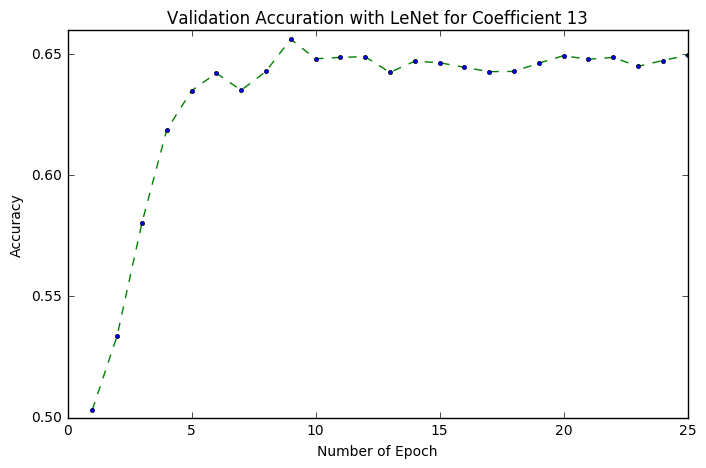

In [164]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with LeNet for Coefficient 13')
plt.show()

In [45]:
model20 = model_lenet()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 11s 396us/step - loss: 2.6437 - acc: 0.3142 - val_loss: 1.6396 - val_acc: 0.4881
Epoch 2/25
27200/27200 [==============================] - 9s 314us/step - loss: 1.4268 - acc: 0.5564 - val_loss: 1.4214 - val_acc: 0.5553
Epoch 3/25
27200/27200 [==============================] - 9s 317us/step - loss: 1.1591 - acc: 0.6359 - val_loss: 1.2791 - val_acc: 0.6050
Epoch 4/25
27200/27200 [==============================] - 9s 316us/step - loss: 1.0014 - acc: 0.6813 - val_loss: 1.2099 - val_acc: 0.6266
Epoch 5/25
27200/27200 [==============================] - 9s 316us/step - loss: 0.8762 - acc: 0.7210 - val_loss: 1.1807 - val_acc: 0.6354
Epoch 6/25
27200/27200 [==============================] - 9s 321us/step - loss: 0.7771 - acc: 0.7505 - val_loss: 1.2089 - val_acc: 0.6396
Epoch 7/25
27200/27200 [==============================] - 9s 320us/step - loss: 0.6983 - acc: 0.7730 - val_loss: 1.2789 - 

In [165]:
graph = {}
graph[1] = 0.4881; graph[6] = 0.6396; graph[11] = 0.6428; graph[16] = 0.6306; graph[21] = 0.6303; 
graph[2] = 0.5553; graph[7] = 0.6357; graph[12] = 0.6369; graph[17] = 0.6285; graph[22] = 0.6319; 
graph[3] = 0.6050; graph[8] = 0.6371; graph[13] = 0.6350; graph[18] = 0.6282; graph[23] = 0.6359; 
graph[4] = 0.6266; graph[9] = 0.6440; graph[14] = 0.6437; graph[19] = 0.6381; graph[24] = 0.6434; 
graph[5] = 0.6354; graph[10] = 0.6343; graph[15] = 0.6341; graph[20] = 0.6326; graph[25] = 0.6341; 

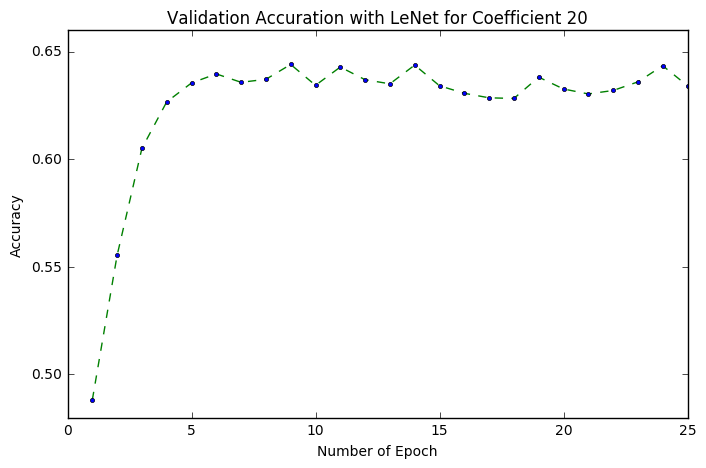

In [166]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with LeNet for Coefficient 20')
plt.show()

In [52]:
model26 = model_lenet()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 13s 475us/step - loss: 2.7351 - acc: 0.2903 - val_loss: 1.7280 - val_acc: 0.4575
Epoch 2/25
27200/27200 [==============================] - 11s 408us/step - loss: 1.4526 - acc: 0.5452 - val_loss: 1.3685 - val_acc: 0.5774
Epoch 3/25
27200/27200 [==============================] - 14s 525us/step - loss: 1.1686 - acc: 0.6297 - val_loss: 1.3848 - val_acc: 0.5721
Epoch 4/25
27200/27200 [==============================] - 13s 478us/step - loss: 0.9929 - acc: 0.6812 - val_loss: 1.2662 - val_acc: 0.6168
Epoch 5/25
27200/27200 [==============================] - 12s 459us/step - loss: 0.8658 - acc: 0.7225 - val_loss: 1.2034 - val_acc: 0.6334
Epoch 6/25
27200/27200 [==============================] - 13s 480us/step - loss: 0.7531 - acc: 0.7560 - val_loss: 1.1918 - val_acc: 0.6476
Epoch 7/25
27200/27200 [==============================] - 13s 469us/step - loss: 0.6566 - acc: 0.7858 - val_loss: 1.3

In [168]:
graph = {}
graph[1] = 0.4575; graph[6] = 0.6476; graph[11] = 0.6351; graph[16] = 0.6299; graph[21] = 0.6334; 
graph[2] = 0.5774; graph[7] = 0.6390; graph[12] = 0.6299; graph[17] = 0.6407; graph[22] = 0.6363; 
graph[3] = 0.5721; graph[8] = 0.6232; graph[13] = 0.6354; graph[18] = 0.6447; graph[23] = 0.6390; 
graph[4] = 0.6168; graph[9] = 0.6360; graph[14] = 0.6362; graph[19] = 0.6443; graph[24] = 0.6312; 
graph[5] = 0.6334; graph[10] = 0.6424; graph[15] = 0.6415; graph[20] = 0.6340; graph[25] = 0.6391; 

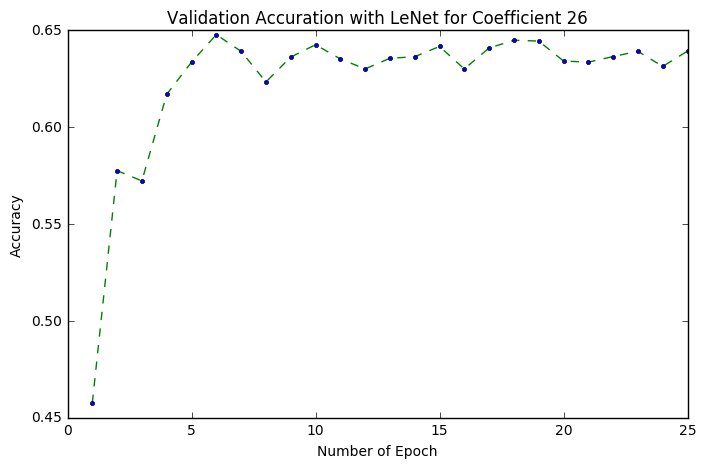

In [169]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with LeNet for Coefficient 26')
plt.show()

## INITIALIZE MODEL SPNET

In [125]:
def model_spnet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), strides=1))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [ ]:
graph = {}
graph[1] = ; graph[6] = ; graph[11] = ; graph[16] = ; graph[21] = ; 
graph[2] = ; graph[7] = ; graph[12] = ; graph[17] = ; graph[22] = ; 
graph[3] = ; graph[8] = ; graph[13] = ; graph[18] = ; graph[23] = ; 
graph[4] = ; graph[9] = ; graph[14] = ; graph[19] = ; graph[24] = ; 
graph[5] = ; graph[10] = ; graph[15] = ; graph[20] = ; graph[25] = ; 

In [105]:
model13 = model_spnet()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 372us/step - loss: 2.7176 - acc: 0.1595 - val_loss: 2.1070 - val_acc: 0.3316
Epoch 2/25
27200/27200 [==============================] - 7s 269us/step - loss: 1.8545 - acc: 0.4107 - val_loss: 1.4648 - val_acc: 0.5321
Epoch 3/25
27200/27200 [==============================] - 8s 297us/step - loss: 1.4205 - acc: 0.5480 - val_loss: 1.4126 - val_acc: 0.5628
Epoch 4/25
27200/27200 [==============================] - 7s 268us/step - loss: 1.2413 - acc: 0.6052 - val_loss: 1.1959 - val_acc: 0.6225
Epoch 5/25
27200/27200 [==============================] - 7s 266us/step - loss: 1.1363 - acc: 0.6372 - val_loss: 1.1516 - val_acc: 0.6376
Epoch 6/25
27200/27200 [==============================] - 8s 288us/step - loss: 1.0620 - acc: 0.6614 - val_loss: 1.1535 - val_acc: 0.6465
Epoch 7/25
27200/27200 [==============================] - 7s 270us/step - loss: 1.0084 - acc: 0.6784 - val_loss: 1.0760 - 

In [161]:
graph = {}
graph[1] = 0.3316; graph[6] = 0.6465; graph[11] = 0.6851; graph[16] = 0.6962; graph[21] = 0.7059; 
graph[2] = 0.5321; graph[7] = 0.6690; graph[12] = 0.6924; graph[17] = 0.6956; graph[22] = 0.7087; 
graph[3] = 0.5628; graph[8] = 0.6535; graph[13] = 0.6578; graph[18] = 0.6841; graph[23] = 0.7156; 
graph[4] = 0.6225; graph[9] = 0.6729; graph[14] = 0.6996; graph[19] = 0.6909; graph[24] = 0.7028; 
graph[5] = 0.6376; graph[10] = 0.6694; graph[15] = 0.6890; graph[20] = 0.7029; graph[25] = 0.7093; 

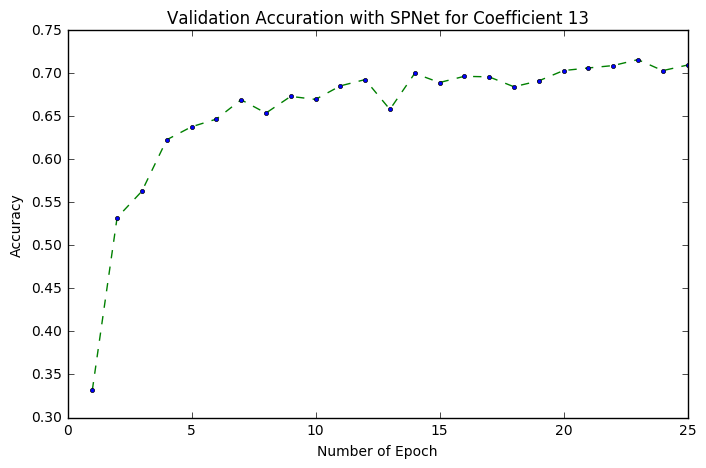

In [162]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet for Coefficient 13')
plt.show()

In [42]:
model20 = model_spnet()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 12s 450us/step - loss: 2.6656 - acc: 0.1787 - val_loss: 2.0087 - val_acc: 0.3538
Epoch 2/25
27200/27200 [==============================] - 10s 385us/step - loss: 1.7350 - acc: 0.4456 - val_loss: 1.4906 - val_acc: 0.5307
Epoch 3/25
27200/27200 [==============================] - 10s 376us/step - loss: 1.3321 - acc: 0.5746 - val_loss: 1.3886 - val_acc: 0.5679
Epoch 4/25
27200/27200 [==============================] - 10s 379us/step - loss: 1.1605 - acc: 0.6296 - val_loss: 1.1022 - val_acc: 0.6515
Epoch 5/25
27200/27200 [==============================] - 11s 388us/step - loss: 1.0544 - acc: 0.6596 - val_loss: 1.3059 - val_acc: 0.6034
Epoch 6/25
27200/27200 [==============================] - 11s 414us/step - loss: 0.9649 - acc: 0.6911 - val_loss: 1.0669 - val_acc: 0.6763
Epoch 7/25
27200/27200 [==============================] - 12s 451us/step - loss: 0.9072 - acc: 0.7088 - val_loss: 1.1

In [154]:
graph = {}
graph[1] = 0.3538; graph[6] = 0.6763; graph[11] = 0.6688; graph[16] = 0.6772; graph[21] = 0.6965; 
graph[2] = 0.5307; graph[7] = 0.6487; graph[12] = 0.6860; graph[17] = 0.7072; graph[22] = 0.7029; 
graph[3] = 0.5679; graph[8] = 0.6754; graph[13] = 0.7004; graph[18] = 0.7001; graph[23] = 0.7026; 
graph[4] = 0.6515; graph[9] = 0.6475; graph[14] = 0.6919; graph[19] = 0.6835; graph[24] = 0.7010; 
graph[5] = 0.6034; graph[10] = 0.6943; graph[15] = 0.6926; graph[20] = 0.7022; graph[25] = 0.7056; 

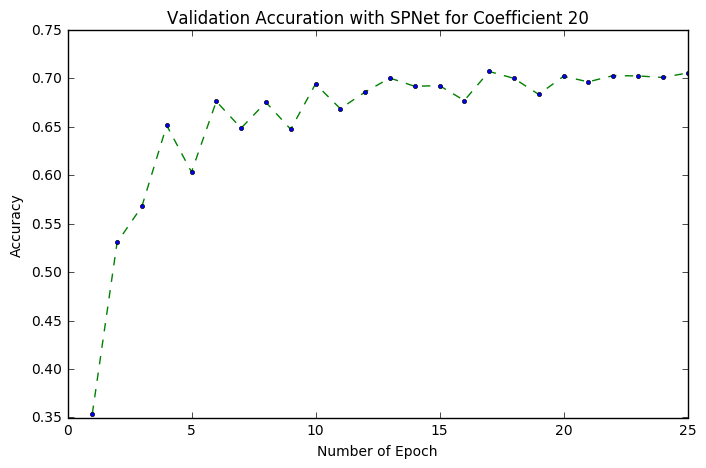

In [155]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet for Coefficient 20')
plt.show()

In [158]:
model26 = model_spnet()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

In [159]:
graph = {}
graph[1] = 0.2891; graph[6] = 0.6381; graph[11] = 0.6897; graph[16] = 0.6906; graph[21] = 0.7004; 
graph[2] = 0.5109; graph[7] = 0.6560; graph[12] = 0.6881; graph[17] = 0.6966; graph[22] = 0.6841; 
graph[3] = 0.5700; graph[8] = 0.6451; graph[13] = 0.6910; graph[18] = 0.7012; graph[23] = 0.6887; 
graph[4] = 0.6057; graph[9] = 0.6896; graph[14] = 0.6894; graph[19] = 0.6832; graph[24] = 0.6875; 
graph[5] = 0.6053; graph[10] = 0.6344; graph[15] = 0.6781; graph[20] = 0.6982; graph[25] = 0.7082; 

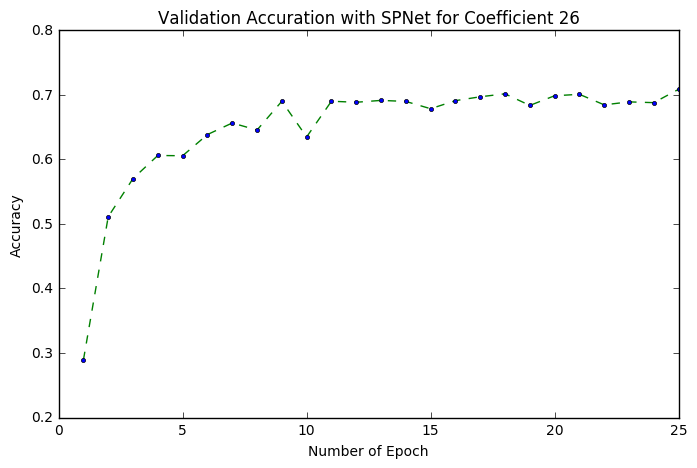

In [160]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet for Coefficient 26')
plt.show()

In [127]:
def model_spnet2():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(2, 2),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(50, kernel_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(2, 2), strides=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [107]:
model13 = model_spnet2()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 6s 220us/step - loss: 3.5652 - acc: 0.1256 - val_loss: 2.5492 - val_acc: 0.1950
Epoch 2/25
27200/27200 [==============================] - 5s 178us/step - loss: 2.3620 - acc: 0.2580 - val_loss: 2.3369 - val_acc: 0.2703
Epoch 3/25
27200/27200 [==============================] - 5s 177us/step - loss: 2.0929 - acc: 0.3368 - val_loss: 2.0492 - val_acc: 0.3431
Epoch 4/25
27200/27200 [==============================] - 4s 164us/step - loss: 1.9359 - acc: 0.3884 - val_loss: 1.8892 - val_acc: 0.3957
Epoch 5/25
27200/27200 [==============================] - 5s 167us/step - loss: 1.8084 - acc: 0.4302 - val_loss: 1.7734 - val_acc: 0.4535
Epoch 6/25
27200/27200 [==============================] - 4s 164us/step - loss: 1.7223 - acc: 0.4529 - val_loss: 1.7399 - val_acc: 0.4507
Epoch 7/25
27200/27200 [==============================] - 4s 162us/step - loss: 1.6495 - acc: 0.4789 - val_loss: 1.7059 - v

In [172]:
graph = {}
graph[1] = 0.1950; graph[6] = 0.4507; graph[11] = 0.5104; graph[16] = 0.5237; graph[21] = 0.5438; 
graph[2] = 0.2703; graph[7] = 0.4576; graph[12] = 0.5171; graph[17] = 0.5329; graph[22] = 0.5357; 
graph[3] = 0.3431; graph[8] = 0.4678; graph[13] = 0.5106; graph[18] = 0.5319; graph[23] = 0.5472; 
graph[4] = 0.3957; graph[9] = 0.4457; graph[14] = 0.5281; graph[19] = 0.5441; graph[24] = 0.5340; 
graph[5] = 0.4535; graph[10] = 0.5046; graph[15] = 0.5187; graph[20] = 0.5429; graph[25] = 0.5607; 

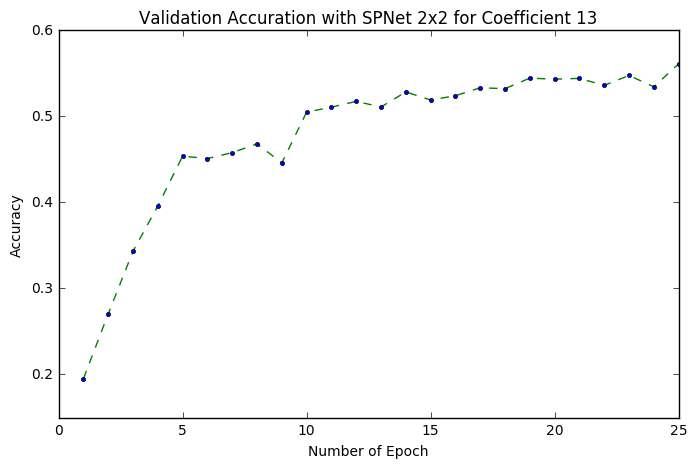

In [173]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 2x2 for Coefficient 13')
plt.show()

In [50]:
model20 = model_spnet2()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 7s 268us/step - loss: 3.1245 - acc: 0.1551 - val_loss: 2.5254 - val_acc: 0.2174
Epoch 2/25
27200/27200 [==============================] - 7s 275us/step - loss: 2.2378 - acc: 0.2971 - val_loss: 2.0411 - val_acc: 0.3557
Epoch 3/25
27200/27200 [==============================] - 7s 241us/step - loss: 1.9402 - acc: 0.3906 - val_loss: 1.8831 - val_acc: 0.4076
Epoch 4/25
27200/27200 [==============================] - 7s 251us/step - loss: 1.7727 - acc: 0.4385 - val_loss: 1.7580 - val_acc: 0.4468
Epoch 5/25
27200/27200 [==============================] - 8s 277us/step - loss: 1.6530 - acc: 0.4783 - val_loss: 1.6866 - val_acc: 0.4799
Epoch 6/25
27200/27200 [==============================] - 7s 269us/step - loss: 1.5646 - acc: 0.5044 - val_loss: 1.6696 - val_acc: 0.4799
Epoch 7/25
27200/27200 [==============================] - 7s 251us/step - loss: 1.5027 - acc: 0.5239 - val_loss: 1.5459 - v

In [174]:
graph = {}
graph[1] = 0.2174; graph[6] = 0.4799; graph[11] = 0.5143; graph[16] = 0.5215; graph[21] = 0.5490; 
graph[2] = 0.3557; graph[7] = 0.5087; graph[12] = 0.5200; graph[17] = 0.5444; graph[22] = 0.5485; 
graph[3] = 0.4076; graph[8] = 0.5210; graph[13] = 0.5528; graph[18] = 0.5565; graph[23] = 0.5594; 
graph[4] = 0.4468; graph[9] = 0.5025; graph[14] = 0.5510; graph[19] = 0.5606; graph[24] = 0.5641; 
graph[5] = 0.4799; graph[10] = 0.5268; graph[15] = 0.5638; graph[20] = 0.5462; graph[25] = 0.5649; 

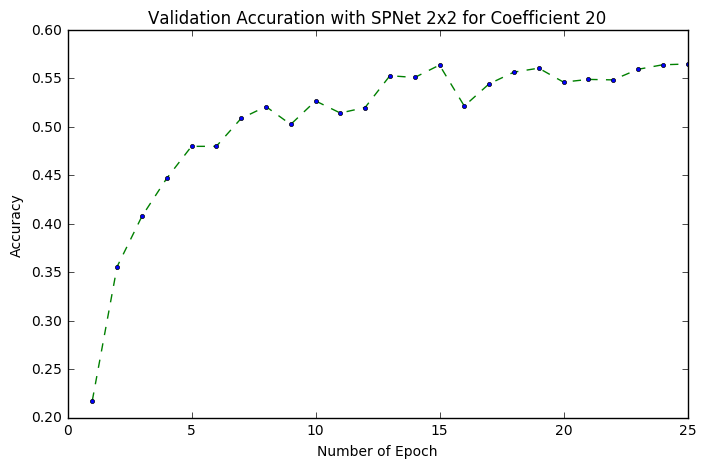

In [175]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 2x2 for Coefficient 20')
plt.show()

In [128]:
model26 = model_spnet2()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 381us/step - loss: 5.0979 - acc: 0.1324 - val_loss: 2.3994 - val_acc: 0.2472
Epoch 2/25
27200/27200 [==============================] - 10s 356us/step - loss: 2.2590 - acc: 0.2892 - val_loss: 2.1128 - val_acc: 0.3512
Epoch 3/25
27200/27200 [==============================] - 9s 323us/step - loss: 1.9438 - acc: 0.3841 - val_loss: 1.8886 - val_acc: 0.4044
Epoch 4/25
27200/27200 [==============================] - 10s 359us/step - loss: 1.7592 - acc: 0.4417 - val_loss: 1.7075 - val_acc: 0.4644
Epoch 5/25
27200/27200 [==============================] - 9s 336us/step - loss: 1.6254 - acc: 0.4815 - val_loss: 1.8426 - val_acc: 0.4221
Epoch 6/25
27200/27200 [==============================] - 8s 305us/step - loss: 1.5344 - acc: 0.5105 - val_loss: 1.6724 - val_acc: 0.4721
Epoch 7/25
27200/27200 [==============================] - 10s 360us/step - loss: 1.4588 - acc: 0.5337 - val_loss: 1.5453

In [176]:
graph = {}
graph[1] = 0.2472; graph[6] = 0.4721; graph[11] = 0.5113; graph[16] = 0.5593; graph[21] = 0.5660; 
graph[2] = 0.3512; graph[7] = 0.5054; graph[12] = 0.5369; graph[17] = 0.5622; graph[22] = 0.5526; 
graph[3] = 0.4044; graph[8] = 0.5225; graph[13] = 0.5428; graph[18] = 0.5601; graph[23] = 0.5549; 
graph[4] = 0.4644; graph[9] = 0.5350; graph[14] = 0.5300; graph[19] = 0.5301; graph[24] = 0.5635; 
graph[5] = 0.4221; graph[10] = 0.4825; graph[15] = 0.5444; graph[20] = 0.5629; graph[25] = 0.5622; 

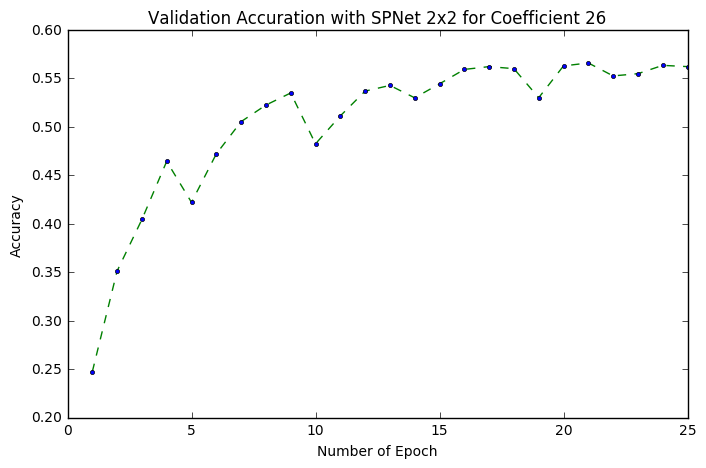

In [177]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 2x2 for Coefficient 26')
plt.show()

In [129]:
def model_spnet3():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(3, 3),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(50, kernel_size=(3, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(3, 3), strides=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [109]:
model13 = model_spnet3()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 378us/step - loss: 3.4471 - acc: 0.1518 - val_loss: 2.4367 - val_acc: 0.2432
Epoch 2/25
27200/27200 [==============================] - 9s 317us/step - loss: 2.0816 - acc: 0.3537 - val_loss: 1.8132 - val_acc: 0.4450
Epoch 3/25
27200/27200 [==============================] - 9s 332us/step - loss: 1.6729 - acc: 0.4733 - val_loss: 1.6023 - val_acc: 0.5054
Epoch 4/25
27200/27200 [==============================] - 8s 295us/step - loss: 1.4561 - acc: 0.5397 - val_loss: 1.3728 - val_acc: 0.5747
Epoch 5/25
27200/27200 [==============================] - 9s 345us/step - loss: 1.3087 - acc: 0.5873 - val_loss: 1.4078 - val_acc: 0.5597
Epoch 6/25
27200/27200 [==============================] - 9s 317us/step - loss: 1.2145 - acc: 0.6181 - val_loss: 1.3519 - val_acc: 0.5896
Epoch 7/25
27200/27200 [==============================] - 9s 319us/step - loss: 1.1326 - acc: 0.6460 - val_loss: 1.2087 - 

In [178]:
graph = {}
graph[1] = 0.2432; graph[6] = 0.5896; graph[11] = 0.6281; graph[16] = 0.6522; graph[21] = 0.6538; 
graph[2] = 0.4450; graph[7] = 0.6196; graph[12] = 0.6449; graph[17] = 0.6666; graph[22] = 0.6699; 
graph[3] = 0.5054; graph[8] = 0.6128; graph[13] = 0.6285; graph[18] = 0.6604; graph[23] = 0.6662; 
graph[4] = 0.5747; graph[9] = 0.6413; graph[14] = 0.6478; graph[19] = 0.6441; graph[24] = 0.6678; 
graph[5] = 0.5597; graph[10] = 0.6121; graph[15] = 0.6272; graph[20] = 0.6643; graph[25] = 0.6690; 

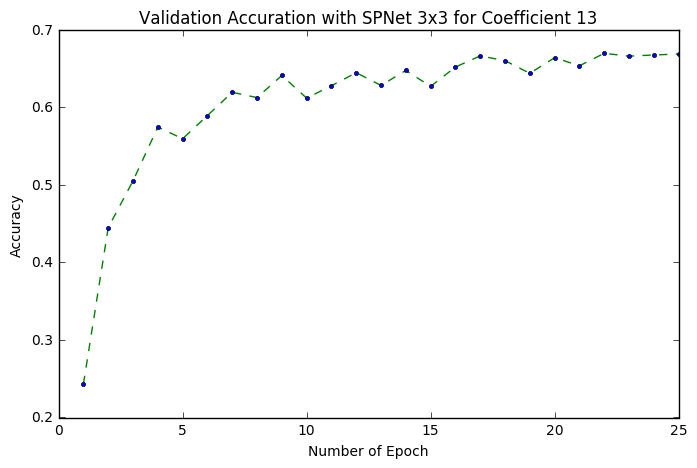

In [179]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 3x3 for Coefficient 13')
plt.show()

In [57]:
model20 = model_spnet3()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 13s 475us/step - loss: 5.0593 - acc: 0.1354 - val_loss: 2.9061 - val_acc: 0.1594
Epoch 2/25
27200/27200 [==============================] - 13s 489us/step - loss: 2.1049 - acc: 0.3463 - val_loss: 1.9982 - val_acc: 0.3818
Epoch 3/25
27200/27200 [==============================] - 12s 458us/step - loss: 1.6582 - acc: 0.4836 - val_loss: 1.6924 - val_acc: 0.4751
Epoch 4/25
27200/27200 [==============================] - 10s 380us/step - loss: 1.4168 - acc: 0.5556 - val_loss: 1.5661 - val_acc: 0.5266
Epoch 5/25
27200/27200 [==============================] - 12s 435us/step - loss: 1.2696 - acc: 0.6004 - val_loss: 1.2874 - val_acc: 0.5959
Epoch 6/25
27200/27200 [==============================] - 14s 513us/step - loss: 1.1477 - acc: 0.6369 - val_loss: 1.3563 - val_acc: 0.5876
Epoch 7/25
27200/27200 [==============================] - 12s 448us/step - loss: 1.0726 - acc: 0.6586 - val_loss: 1.2

In [180]:
graph = {}
graph[1] = 0.1594; graph[6] = 0.5876; graph[11] = 0.6431; graph[16] = 0.6784; graph[21] = 0.6729; 
graph[2] = 0.3818; graph[7] = 0.6112; graph[12] = 0.6624; graph[17] = 0.6737; graph[22] = 0.6641; 
graph[3] = 0.4751; graph[8] = 0.6384; graph[13] = 0.6619; graph[18] = 0.6582; graph[23] = 0.6601; 
graph[4] = 0.5266; graph[9] = 0.6441; graph[14] = 0.6712; graph[19] = 0.6622; graph[24] = 0.6654; 
graph[5] = 0.5959; graph[10] = 0.6310; graph[15] = 0.6651; graph[20] = 0.6624; graph[25] = 0.6628; 

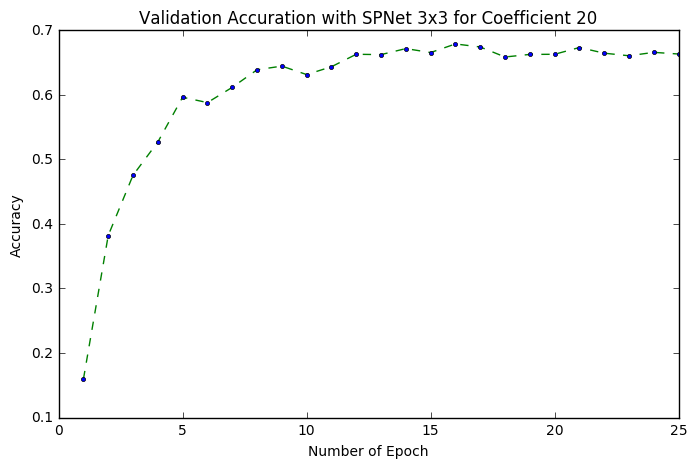

In [181]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 3x3 for Coefficient 20')
plt.show()

In [130]:
model26 = model_spnet3()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 15s 570us/step - loss: 3.2705 - acc: 0.1818 - val_loss: 2.2533 - val_acc: 0.2903
Epoch 2/25
27200/27200 [==============================] - 13s 482us/step - loss: 1.9044 - acc: 0.4050 - val_loss: 1.9178 - val_acc: 0.4187
Epoch 3/25
27200/27200 [==============================] - 16s 576us/step - loss: 1.4904 - acc: 0.5324 - val_loss: 1.3716 - val_acc: 0.5690
Epoch 4/25
27200/27200 [==============================] - 16s 579us/step - loss: 1.2766 - acc: 0.5944 - val_loss: 1.3087 - val_acc: 0.5938
Epoch 5/25
27200/27200 [==============================] - 15s 560us/step - loss: 1.1372 - acc: 0.6397 - val_loss: 1.2398 - val_acc: 0.6099
Epoch 6/25
27200/27200 [==============================] - 14s 531us/step - loss: 1.0375 - acc: 0.6706 - val_loss: 1.1583 - val_acc: 0.6394
Epoch 7/25
27200/27200 [==============================] - 16s 582us/step - loss: 0.9617 - acc: 0.6932 - val_loss: 1.1

In [182]:
graph = {}
graph[1] = 0.2903; graph[6] = 0.6394; graph[11] = 0.6537; graph[16] = 0.6643; graph[21] = 0.6856; 
graph[2] = 0.4187; graph[7] = 0.6522; graph[12] = 0.6800; graph[17] = 0.6644; graph[22] = 0.6640; 
graph[3] = 0.5690; graph[8] = 0.6462; graph[13] = 0.6771; graph[18] = 0.6796; graph[23] = 0.6746; 
graph[4] = 0.5938; graph[9] = 0.6681; graph[14] = 0.6644; graph[19] = 0.6835; graph[24] = 0.6851; 
graph[5] = 0.6099; graph[10] = 0.6640; graph[15] = 0.6863; graph[20] = 0.6763; graph[25] = 0.6744; 

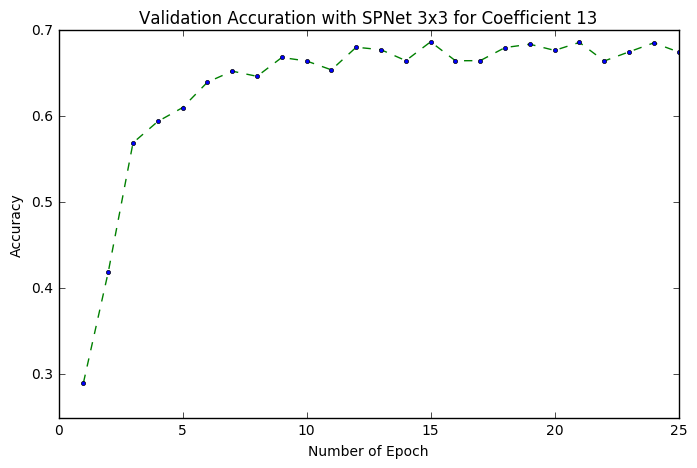

In [183]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 3x3 for Coefficient 13')
plt.show()

In [174]:
def model_spnet4():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(4, 4),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(4, 4)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(4, 4), strides=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [175]:
model13 = model_spnet4()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 29s 1ms/step - loss: 3.0817 - acc: 0.2203 - val_loss: 1.8658 - val_acc: 0.4026
Epoch 2/25
27200/27200 [==============================] - 26s 957us/step - loss: 1.6357 - acc: 0.4861 - val_loss: 1.3673 - val_acc: 0.5688
Epoch 3/25
27200/27200 [==============================] - 28s 1ms/step - loss: 1.2470 - acc: 0.6025 - val_loss: 1.3321 - val_acc: 0.5881
Epoch 4/25
27200/27200 [==============================] - 27s 981us/step - loss: 1.0724 - acc: 0.6585 - val_loss: 1.0906 - val_acc: 0.6604
Epoch 5/25
27200/27200 [==============================] - 28s 1ms/step - loss: 0.9364 - acc: 0.7017 - val_loss: 1.0633 - val_acc: 0.6732
Epoch 6/25
27200/27200 [==============================] - 27s 998us/step - loss: 0.8468 - acc: 0.7292 - val_loss: 1.0264 - val_acc: 0.6872
Epoch 7/25
27200/27200 [==============================] - 27s 994us/step - loss: 0.7673 - acc: 0.7519 - val_loss: 1.0185 - 

In [184]:
graph = {}
graph[1] = 0.4026; graph[6] = 0.6872; graph[11] = 0.7218; graph[16] = 0.7044; graph[21] = 0.7013; 
graph[2] = 0.5688; graph[7] = 0.7013; graph[12] = 0.7181; graph[17] = 0.7175; graph[22] = 0.7174; 
graph[3] = 0.5881; graph[8] = 0.7021; graph[13] = 0.7074; graph[18] = 0.6957; graph[23] = 0.7150; 
graph[4] = 0.6604; graph[9] = 0.6931; graph[14] = 0.7116; graph[19] = 0.7172; graph[24] = 0.7015; 
graph[5] = 0.6732; graph[10] = 0.6951; graph[15] = 0.7159; graph[20] = 0.7172; graph[25] = 0.7050; 

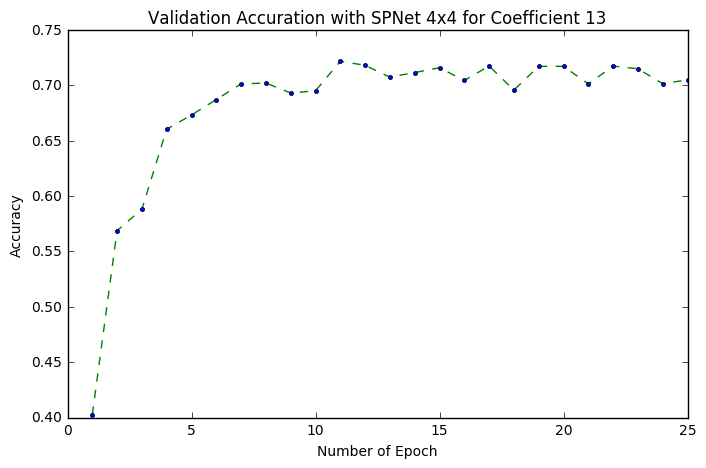

In [185]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 4x4 for Coefficient 13')
plt.show()

In [66]:
model20 = model_spnet4()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 19s 710us/step - loss: 5.2378 - acc: 0.1738 - val_loss: 2.0903 - val_acc: 0.3341
Epoch 2/25
27200/27200 [==============================] - 19s 709us/step - loss: 1.6842 - acc: 0.4661 - val_loss: 1.3792 - val_acc: 0.5631
Epoch 3/25
27200/27200 [==============================] - 19s 687us/step - loss: 1.2857 - acc: 0.5936 - val_loss: 1.2577 - val_acc: 0.5966
Epoch 4/25
27200/27200 [==============================] - 20s 720us/step - loss: 1.0801 - acc: 0.6589 - val_loss: 1.0930 - val_acc: 0.6610
Epoch 5/25
27200/27200 [==============================] - 20s 737us/step - loss: 0.9574 - acc: 0.6950 - val_loss: 1.2019 - val_acc: 0.6366
Epoch 6/25
27200/27200 [==============================] - 20s 742us/step - loss: 0.8744 - acc: 0.7193 - val_loss: 1.0928 - val_acc: 0.6557
Epoch 7/25
27200/27200 [==============================] - 19s 705us/step - loss: 0.7932 - acc: 0.7438 - val_loss: 1.0

In [2]:
graph = {}
graph[1] = 0.3341; graph[6] = 0.6557; graph[11] = 0.7185; graph[16] = 0.7053; graph[21] = 0.7094; 
graph[2] = 0.5631; graph[7] = 0.6768; graph[12] = 0.7129; graph[17] = 0.7156; graph[22] = 0.7194; 
graph[3] = 0.5966; graph[8] = 0.6790; graph[13] = 0.7109; graph[18] = 0.7096; graph[23] = 0.7079; 
graph[4] = 0.6610; graph[9] = 0.7026; graph[14] = 0.7151; graph[19] = 0.7182; graph[24] = 0.7069; 
graph[5] = 0.6366; graph[10] = 0.7093; graph[15] = 0.7165; graph[20] = 0.7185; graph[25] = 0.7026; 

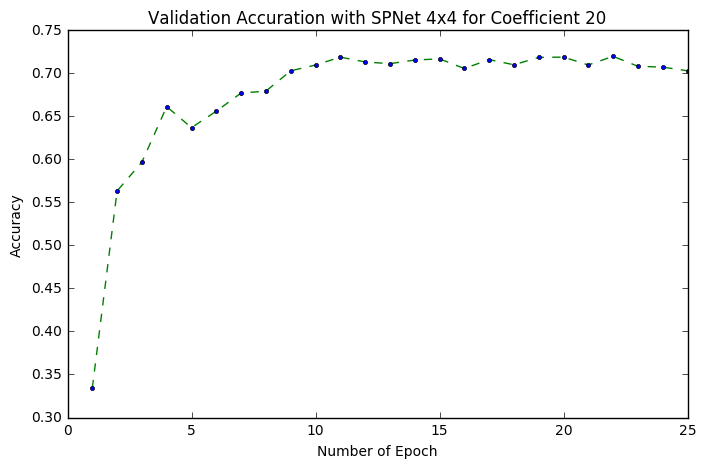

In [4]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 4x4 for Coefficient 20')
plt.show()

In [137]:
model26 = model_spnet4()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 29s 1ms/step - loss: 6.2586 - acc: 0.1556 - val_loss: 2.0911 - val_acc: 0.3350
Epoch 2/25
27200/27200 [==============================] - 27s 986us/step - loss: 1.7286 - acc: 0.4544 - val_loss: 1.4135 - val_acc: 0.5624
Epoch 3/25
27200/27200 [==============================] - 25s 926us/step - loss: 1.2750 - acc: 0.5956 - val_loss: 1.2007 - val_acc: 0.6194
Epoch 4/25
27200/27200 [==============================] - 25s 935us/step - loss: 1.0691 - acc: 0.6625 - val_loss: 1.1038 - val_acc: 0.6578
Epoch 5/25
27200/27200 [==============================] - 25s 935us/step - loss: 0.9404 - acc: 0.6976 - val_loss: 1.0260 - val_acc: 0.6746
Epoch 6/25
27200/27200 [==============================] - 26s 944us/step - loss: 0.8445 - acc: 0.7275 - val_loss: 1.1364 - val_acc: 0.6501
Epoch 7/25
27200/27200 [==============================] - 26s 964us/step - loss: 0.7695 - acc: 0.7492 - val_loss: 0.970

In [5]:
graph = {}
graph[1] = 0.3350; graph[6] = 0.6501; graph[11] = 0.7219; graph[16] = 0.7096; graph[21] = 0.7109; 
graph[2] = 0.5624; graph[7] = 0.7046; graph[12] = 0.7065; graph[17] = 0.7151; graph[22] = 0.7124; 
graph[3] = 0.6194; graph[8] = 0.6966; graph[13] = 0.6990; graph[18] = 0.7063; graph[23] = 0.7238; 
graph[4] = 0.6578; graph[9] = 0.6993; graph[14] = 0.7001; graph[19] = 0.7232; graph[24] = 0.7153; 
graph[5] = 0.6746; graph[10] = 0.7135; graph[15] = 0.7249; graph[20] = 0.6993; graph[25] = 0.7038; 

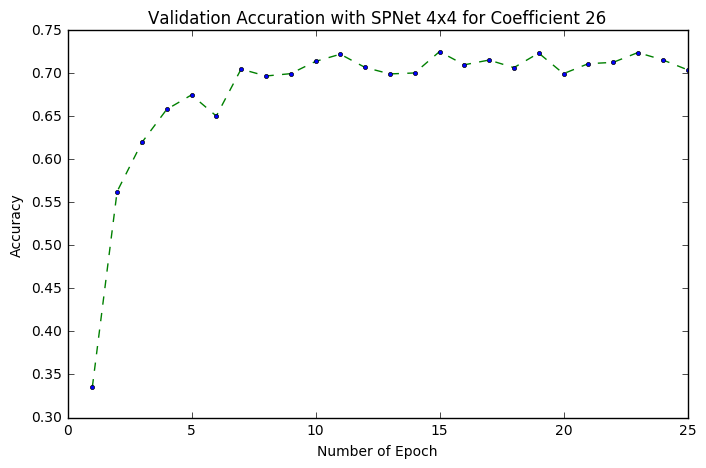

In [6]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 4x4 for Coefficient 26')
plt.show()

In [133]:
def model_spnet6():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(6, 6),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(6, 6)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(6, 6), strides=1))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [113]:
model13 = model_spnet6()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 17s 618us/step - loss: 2.6729 - acc: 0.2125 - val_loss: 2.1845 - val_acc: 0.3174
Epoch 2/25
27200/27200 [==============================] - 17s 622us/step - loss: 1.6390 - acc: 0.4791 - val_loss: 1.4190 - val_acc: 0.5522
Epoch 3/25
27200/27200 [==============================] - 18s 658us/step - loss: 1.3094 - acc: 0.5846 - val_loss: 1.1764 - val_acc: 0.6306
Epoch 4/25
27200/27200 [==============================] - 19s 685us/step - loss: 1.1274 - acc: 0.6417 - val_loss: 1.1712 - val_acc: 0.6387
Epoch 5/25
27200/27200 [==============================] - 19s 700us/step - loss: 1.0246 - acc: 0.6760 - val_loss: 1.0804 - val_acc: 0.6679
Epoch 6/25
27200/27200 [==============================] - 18s 665us/step - loss: 0.9369 - acc: 0.7030 - val_loss: 1.1451 - val_acc: 0.6538
Epoch 7/25
27200/27200 [==============================] - 16s 594us/step - loss: 0.8761 - acc: 0.7211 - val_loss: 1.0

In [17]:
graph = {}
graph[1] = 0.3174; graph[6] = 0.6538; graph[11] = 0.7094; graph[16] = 0.6972; graph[21] = 0.7197; 
graph[2] = 0.5522; graph[7] = 0.6825; graph[12] = 0.6963; graph[17] = 0.7147; graph[22] = 0.7025; 
graph[3] = 0.6306; graph[8] = 0.6788; graph[13] = 0.7104; graph[18] = 0.7181; graph[23] = 0.7296; 
graph[4] = 0.6387; graph[9] = 0.7062; graph[14] = 0.7116; graph[19] = 0.7149; graph[24] = 0.7109; 
graph[5] = 0.6679; graph[10] = 0.7041; graph[15] = 0.7124; graph[20] = 0.7237; graph[25] = 0.7143; 

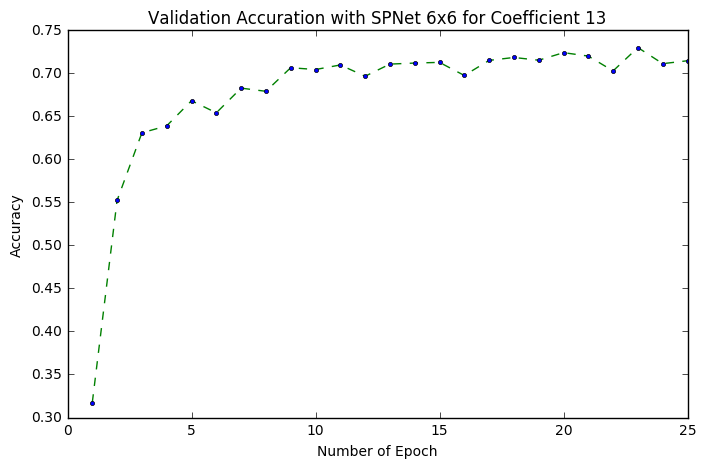

In [18]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 6x6 for Coefficient 13')
plt.show()

In [98]:
model20 = model_spnet6()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 21s 758us/step - loss: 2.9676 - acc: 0.1942 - val_loss: 1.9554 - val_acc: 0.3696
Epoch 2/25
27200/27200 [==============================] - 22s 810us/step - loss: 1.6858 - acc: 0.4659 - val_loss: 1.4365 - val_acc: 0.5465
Epoch 3/25
27200/27200 [==============================] - 21s 777us/step - loss: 1.2999 - acc: 0.5860 - val_loss: 1.2024 - val_acc: 0.6147
Epoch 4/25
27200/27200 [==============================] - 20s 752us/step - loss: 1.1114 - acc: 0.6450 - val_loss: 1.1467 - val_acc: 0.6428
Epoch 5/25
27200/27200 [==============================] - 22s 827us/step - loss: 0.9886 - acc: 0.6845 - val_loss: 1.0908 - val_acc: 0.6663
Epoch 6/25
27200/27200 [==============================] - 24s 868us/step - loss: 0.9080 - acc: 0.7099 - val_loss: 1.1539 - val_acc: 0.6488
Epoch 7/25
27200/27200 [==============================] - 21s 769us/step - loss: 0.8166 - acc: 0.7382 - val_loss: 1.0

In [20]:
graph = {}
graph[1] = 0.3696; graph[6] = 0.6488; graph[11] = 0.7110; graph[16] = 0.7068; graph[21] = 0.7118; 
graph[2] = 0.5465; graph[7] = 0.6810; graph[12] = 0.6969; graph[17] = 0.7041; graph[22] = 0.6999; 
graph[3] = 0.6147; graph[8] = 0.6813; graph[13] = 0.6963; graph[18] = 0.7193; graph[23] = 0.7093; 
graph[4] = 0.6428; graph[9] = 0.6715; graph[14] = 0.7174; graph[19] = 0.7146; graph[24] = 0.7050; 
graph[5] = 0.6663; graph[10] = 0.7151; graph[15] = 0.7107; graph[20] = 0.7204; graph[25] = 0.7026; 

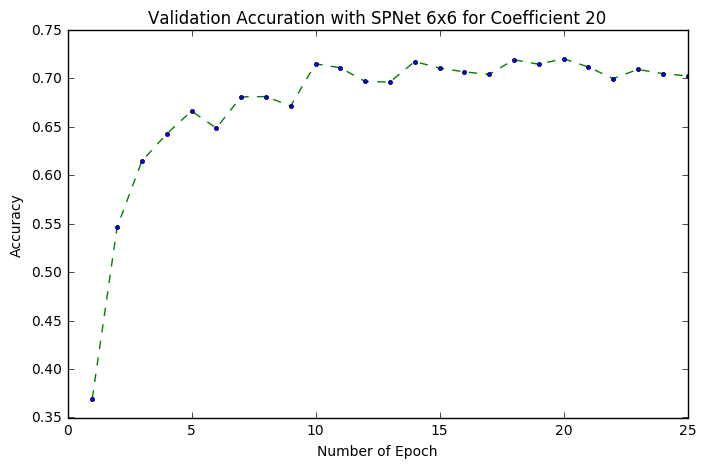

In [21]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 6x6 for Coefficient 20')
plt.show()

In [134]:
model26 = model_spnet6()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 30s 1ms/step - loss: 3.5614 - acc: 0.1514 - val_loss: 2.0674 - val_acc: 0.3212
Epoch 2/25
27200/27200 [==============================] - 28s 1ms/step - loss: 1.8293 - acc: 0.4146 - val_loss: 1.4529 - val_acc: 0.5313
Epoch 3/25
27200/27200 [==============================] - 28s 1ms/step - loss: 1.3534 - acc: 0.5678 - val_loss: 1.2423 - val_acc: 0.6113
Epoch 4/25
27200/27200 [==============================] - 28s 1ms/step - loss: 1.1318 - acc: 0.6392 - val_loss: 1.3178 - val_acc: 0.5969
Epoch 5/25
27200/27200 [==============================] - 28s 1ms/step - loss: 1.0050 - acc: 0.6775 - val_loss: 1.2494 - val_acc: 0.6194
Epoch 6/25
27200/27200 [==============================] - 28s 1ms/step - loss: 0.9126 - acc: 0.7071 - val_loss: 1.0721 - val_acc: 0.6697
Epoch 7/25
27200/27200 [==============================] - 28s 1ms/step - loss: 0.8297 - acc: 0.7336 - val_loss: 0.9632 - val_acc:

In [22]:
graph = {}
graph[1] = 0.3212; graph[6] = 0.6697; graph[11] = 0.7006; graph[16] = 0.6840; graph[21] = 0.6978; 
graph[2] = 0.5313; graph[7] = 0.7046; graph[12] = 0.7071; graph[17] = 0.7276; graph[22] = 0.7056; 
graph[3] = 0.6113; graph[8] = 0.6924; graph[13] = 0.7037; graph[18] = 0.7253; graph[23] = 0.7131; 
graph[4] = 0.5969; graph[9] = 0.7022; graph[14] = 0.7125; graph[19] = 0.7069; graph[24] = 0.7109; 
graph[5] = 0.6194; graph[10] = 0.7103; graph[15] = 0.7172; graph[20] = 0.6951; graph[25] = 0.7144; 

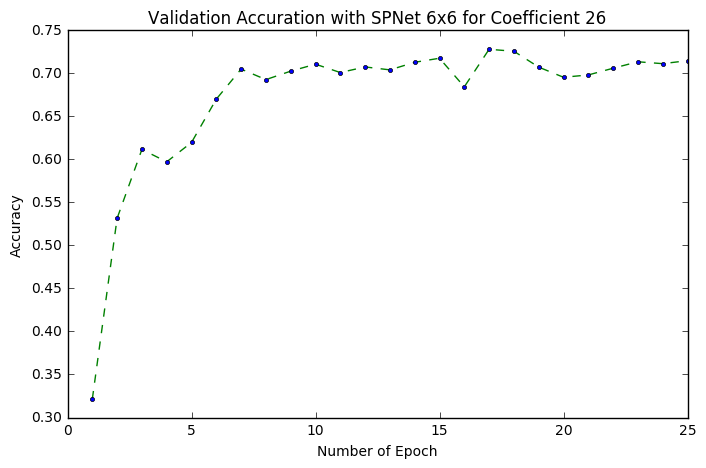

In [23]:
x = list(graph.keys())
y = list(graph.values())
plt.figure(figsize=(8,5))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=3)
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuration with SPNet 6x6 for Coefficient 26')
plt.show()

In [71]:
spnet = {}
lenet = {}
spnet_k2 = {}
spnet_k3 = {}
spnet_k4 = {}
spnet_k6 = {}

In [72]:
spnet[1] = 0.1787; spnet[5] = 0.6596; spnet[10] = 0.7541; spnet[15] = 0.7986; spnet[20] = 0.8318; spnet[25] = 0.8607; 

In [73]:
lenet[1] = 0.3142; lenet[5] = 0.7210; lenet[10] = 0.8449; lenet[15] = 0.9179; lenet[20] = 0.9510; lenet[25] = 0.9735; 

In [74]:
spnet_k2[1] = 0.1551; spnet_k2[5] = 0.4783; spnet_k2[10] = 0.5693; spnet_k2[15] = 0.6156; spnet_k2[20] = 0.6479; spnet_k2[25] = 0.6803; 

In [75]:
spnet_k3[1] = 0.1354; spnet_k3[5] = 0.6004; spnet_k3[10] = 0.7121; spnet_k3[15] = 0.7724; spnet_k3[20] = 0.8192; spnet_k3[25] = 0.8536; 

In [76]:
spnet_k4[1] = 0.1738; spnet_k4[5] = 0.6950; spnet_k4[10] = 0.7905; spnet_k4[15] = 0.8493; spnet_k4[20] = 0.8928; spnet_k4[25] = 0.9222; 

In [77]:
spnet_k6[1] = 0.1942; spnet_k6[5] = 0.6845; spnet_k6[10] = 0.7812; spnet_k6[15] = 0.8385; spnet_k6[20] = 0.8787; spnet_k6[25] = 0.9095; 

In [78]:
tabel_acc20 = pd.DataFrame([spnet.keys(),spnet.values(),lenet.values(),spnet_k2.values(),spnet_k3.values(),spnet_k4.values(),spnet_k6.values()])
tabel_acc20 = tabel_acc20.T
tabel_acc20.columns = ['number of epoch','SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']
tabel_acc20_val = pd.DataFrame([0.7056,0.6440,0.5649, 0.6784,0.7194,0.7204])
tabel_acc20_val = tabel_acc20_val.T
tabel_acc20_val.columns = ['SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']

## MODEL ACCURATION FOR KOEFISIEN 20

In [79]:
tabel_acc20

,number of epoch,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,1.0,0.1787,0.3142,0.1551,0.1354,0.1738,0.1942
1,5.0,0.6596,0.7210,0.4783,0.6004,0.6950,0.6845
2,10.0,0.7541,0.8449,0.5693,0.7121,0.7905,0.7812
3,15.0,0.7986,0.9179,0.6156,0.7724,0.8493,0.8385
4,20.0,0.8318,0.9510,0.6479,0.8192,0.8928,0.8787
5,25.0,0.8607,0.9735,0.6803,0.8536,0.9222,0.9095


## VALIDATION ACCURATION FOR COEFFICIENT 20

In [148]:
tabel_acc20_val

,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,0.7056,0.6553,0.5649,0.6784,0.7194,0.7204


In [80]:
spnet13 = {}
lenet13 = {}
spnet13_k2 = {}
spnet13_k3 = {}
spnet13_k4 = {}
spnet13_k6 = {}

In [81]:
spnet13[1] = 0.1595; spnet13[5] = 0.6372; spnet13[10] = 0.7174; spnet13[15] = 0.7582; spnet13[20] = 0.7828; spnet13[25] = 0.8031; 

In [82]:
lenet13[1] = 0.3281; lenet13[5] = 0.6852; lenet13[10] = 0.7840; lenet13[15] = 0.8528; lenet13[20] = 0.9013; lenet13[25] = 0.9305; 

In [83]:
spnet13_k2[1] = 0.1256; spnet13_k2[5] = 0.4302; spnet13_k2[10] = 0.5223; spnet13_k2[15] = 0.5651; spnet13_k2[20] = 0.5998; spnet13_k2[25] = 0.6269; 

In [84]:
spnet13_k3[1] = 0.1518; spnet13_k3[5] = 0.5873; spnet13_k3[10] = 0.6916; spnet13_k3[15] = 0.7483; spnet13_k3[20] = 0.7824; spnet13_k3[25] = 0.8215; 

In [85]:
spnet13_k4[1] = 0.2203; spnet13_k4[5] = 0.7017; spnet13_k4[10] = 0.8057; spnet13_k4[15] = 0.8676; spnet13_k4[20] = 0.9068; spnet13_k4[25] = 0.9319; 

In [86]:
spnet13_k6[1] = 0.2125; spnet13_k6[5] = 0.6760; spnet13_k6[10] = 0.7656; spnet13_k6[15] = 0.8102; spnet13_k6[20] = 0.8511; spnet13_k6[25] = 0.8734; 

In [87]:
tabel_acc13 = pd.DataFrame([spnet13.keys(),spnet13.values(),lenet13.values(),spnet13_k2.values(),spnet13_k3.values(),spnet13_k4.values(),spnet13_k6.values()])
tabel_acc13 = tabel_acc13.T
tabel_acc13.columns = ['number of epoch','SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']
tabel_acc13_val = pd.DataFrame([0.7093,0.6440,0.5607,0.6699,0.7218,0.7296])
tabel_acc13_val = tabel_acc13_val.T
tabel_acc13_val.columns = ['SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']

## MODEL ACCURATION FOR COEFFICIENT 13

In [88]:
tabel_acc13

,number of epoch,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,1.0,0.1595,0.3281,0.1256,0.1518,0.2203,0.2125
1,5.0,0.6372,0.6852,0.4302,0.5873,0.7017,0.6760
2,10.0,0.7174,0.7840,0.5223,0.6916,0.8057,0.7656
3,15.0,0.7582,0.8528,0.5651,0.7483,0.8676,0.8102
4,20.0,0.7828,0.9013,0.5998,0.7824,0.9068,0.8511
5,25.0,0.8031,0.9305,0.6269,0.8215,0.9319,0.8734


## VALIDATION ACCURATION FOR COEFFICIENT 13

In [89]:
tabel_acc13_val

,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,0.7093,0.644,0.5607,0.6699,0.7218,0.7296


In [90]:
spnet26 = {}
lenet26 = {}
spnet26_k2 = {}
spnet26_k3 = {}
spnet26_k4 = {}
spnet26_k6 = {}

In [91]:
spnet26[1] = 0.1707; spnet26[5] = 0.6475; spnet26[10] = 0.7446; spnet26[15] = 0.7990; spnet26[20] = 0.8366; spnet26[25] = 0.8676; 

In [92]:
lenet26[1] = 0.2903; lenet26[5] = 0.7225; lenet26[10] = 0.8623; lenet26[15] = 0.9408; lenet26[20] = 0.9742; lenet26[25] = 0.9813;

In [93]:
spnet26_k2[1] = 0.1324; spnet26_k2[5] = 0.4815; spnet26_k2[10] = 0.5792; spnet26_k2[15] = 0.6421; spnet26_k2[20] = 0.6821; spnet26_k2[25] = 0.7170; 

In [94]:
spnet26_k3[1] = 0.1818; spnet26_k3[5] = 0.6397; spnet26_k3[10] = 0.7464; spnet26_k3[15] = 0.8063; spnet26_k3[20] = 0.8545; spnet26_k3[25] = 0.8893; 

In [95]:
spnet26_k4[1] = 0.1556; spnet26_k4[5] = 0.6976; spnet26_k4[10] = 0.8033; spnet26_k4[15] = 0.8673; spnet26_k4[20] = 0.9060; spnet26_k4[25] = 0.9322; 

In [96]:
spnet26_k6[1] = 0.1514; spnet26_k6[5] = 0.6775; spnet26_k6[10] = 0.7850; spnet26_k6[15] = 0.8429; spnet26_k6[20] = 0.8844; spnet26_k6[25] = 0.9161; 

In [97]:
tabel_acc26 = pd.DataFrame([spnet26.keys(),spnet26.values(),lenet26.values(),spnet26_k2.values(),spnet26_k3.values(),spnet26_k4.values(),spnet26_k6.values()])
tabel_acc26 = tabel_acc26.T
tabel_acc26.columns = ['number of epoch','SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']
tabel_acc26_val = pd.DataFrame([0.7082,0.6476,0.5635,0.6856,0.7249,0.7276])
tabel_acc26_val = tabel_acc26_val.T
tabel_acc26_val.columns = ['SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']

## MODEL ACCURATION FOR COEFFICIENT 26

In [98]:
tabel_acc26

,number of epoch,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,1.0,0.1707,0.2903,0.1324,0.1818,0.1556,0.1514
1,5.0,0.6475,0.7225,0.4815,0.6397,0.6976,0.6775
2,10.0,0.7446,0.8623,0.5792,0.7464,0.8033,0.7850
3,15.0,0.7990,0.9408,0.6421,0.8063,0.8673,0.8429
4,20.0,0.8366,0.9742,0.6821,0.8545,0.9060,0.8844
5,25.0,0.8676,0.9813,0.7170,0.8893,0.9322,0.9161


## VALIDATION ACCURATION FOR COEFFICIENT 26

In [99]:
tabel_acc26_val

,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,0.7082,0.6476,0.5635,0.6856,0.7249,0.7276


In [100]:
sp_graph = {}
lenet_graph = {}
spnet2_graph = {}
spnet3_graph = {}
spnet4_graph = {}
spnet6_graph = {}
sp_graph[13] = 0.7093; lenet_graph[13] = 0.6496; spnet2_graph[13] = 0.5607; spnet3_graph[13] = 0.6699; spnet4_graph[13] = 0.7312; spnet6_graph[13] = 0.7296;
sp_graph[20] = 0.7056; lenet_graph[20] = 0.6440; spnet2_graph[20] = 0.5649; spnet3_graph[20] = 0.6784; spnet4_graph[20] = 0.7194; spnet6_graph[20] = 0.7204;
sp_graph[26] = 0.7082; lenet_graph[26] = 0.6476; spnet2_graph[26] = 0.5635; spnet3_graph[26] = 0.6856; spnet4_graph[26] = 0.7249; spnet6_graph[26] = 0.7276;

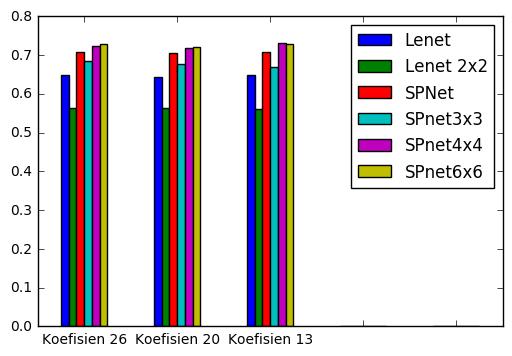

In [101]:
sp = [sp_graph[26],sp_graph[20],sp_graph[13],0,0]
le = [lenet_graph[26],lenet_graph[20],lenet_graph[13],0,0]
sp2 = [spnet2_graph[26],spnet2_graph[20],spnet2_graph[13],0,0]
sp3 = [spnet3_graph[26],spnet3_graph[20],spnet3_graph[13],0,0]
sp4 = [spnet4_graph[26],spnet4_graph[20],spnet4_graph[13],0,0]
sp6 = [spnet6_graph[26],spnet6_graph[20],spnet6_graph[13],0,0]
index = ["Koefisien 26",'Koefisien 20','Koefisien 13','','']
df = pd.DataFrame({'SPNet': sp,'Lenet': le,'Lenet 2x2': sp2,'SPnet3x3': sp3,'SPnet4x4': sp4,'SPnet6x6': sp6}, index=index)
ax = df.plot.bar(rot=0)
plt.show()

In [187]:
tp = {}
fp = {}
fn = {}

In [188]:
for i in labels:
    tp[i] = 0
    fp[i] = 0
    fn[i] = 0

In [189]:
count = 0
for i in range(0,6800):
    sample = X_test[i].reshape(1, feature_dim_1, feature_dim_2, channel)
    prediction = get_labels()[0][np.argmax(model26.predict(sample))]
    real = get_labels()[0][np.argmax(y_test_hot[i])]
    if (real == prediction):
        count+=1
        tp[real]+=1
    else:
        fn[prediction]+=1
        fp[real]+=1

In [192]:
precision = {}
recall = {}
f1 = {}
accurationn = {}
error_rate = {}
for i in labels:
    precision[i] = 0
    recall[i] = 0
    f1[i] = 0
    error_rate[i] = 0

In [193]:
from __future__ import division
for i in labels:
    precision[i] = tp[i]/(tp[i]+fp[i])
    recall[i] = tp[i]/(tp[i]+fn[i])
    f1[i] = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
    error_rate[i] = 1-precision[i]

In [194]:
tabel_acc26_val = pd.DataFrame([precision.keys(),precision.values(),recall.values(),f1.values(),error_rate.values()])
tabel_acc26_val = tabel_acc26_val.T
tabel_acc26_val.columns = ['Label', 'Precision / Accuration', 'Recall', 'F - Measure','Error Rate']

## Confusion Matrix

In [195]:
tabel_acc26_val

,Label,Precision / Accuration,Recall,F - Measure,Error Rate
0,sheila,0.79375,0.731988,0.761619,0.20625
1,seven,0.705521,0.59126,0.643357,0.294479
2,right,0.584098,0.84141,0.689531,0.415902
3,three,0.67341,0.774086,0.720247,0.32659
4,no,0.643059,0.656069,0.649499,0.356941
5,marvin,0.806548,0.754875,0.779856,0.193452
6,wow,0.807365,0.833333,0.820144,0.192635
7,six,0.664706,0.833948,0.739771,0.335294
8,stop,0.635389,0.769481,0.696035,0.364611
9,up,0.696697,0.640884,0.667626,0.303303


## EXAMPLE PREDICTION OF VOICE 

In [203]:
print(predict('/home/daniel/data/zero/1c1060b1_nohash_1.wav', model=model13))

sheila
